In [47]:
import os, sys
sys.path.insert(0, os.path.abspath('..'))
import copy 
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import linprog
from scipy.optimize import minimize 
from scipy.optimize import minimize_scalar
import QUAD as QUAD
import nashpy as nash
from scipy.stats import expon
from scipy.integrate import quad
from statsmodels.distributions.empirical_distribution import ECDF
from scipy import interpolate 


## 4

In [48]:
p = pd.read_csv('auction_prices.csv') # read data
p = p['price'].values # convert to numpy

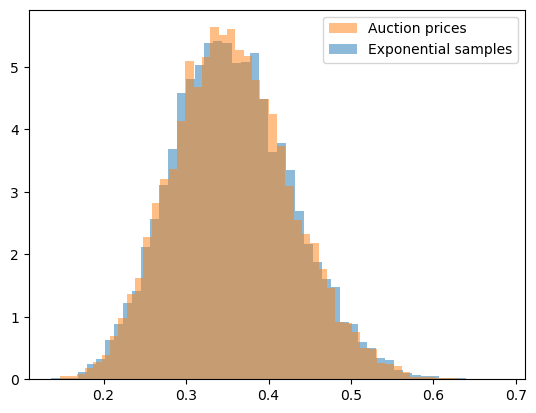

In [49]:
T = 10000

#copy p
p1 = p.copy()

#seed
np.random.seed(1337)

samples = np.random.beta(4.305,10, size=(5,T))
samples.sort(axis=0)
win = samples[-2,:] # second highest bid
plt.hist(win, bins=50, density=True,alpha=0.5)
plt.hist(p1, bins=50, density=True, alpha=0.5,label='observed prices')

plt.legend(['Auction prices', 'Exponential samples'])



In [50]:
n = 5
R = 10000

def predict_distribution(k): 
    np.random.seed(1337) 
    v = np.random.beta(k,10, size=(5,T))
    w = np.sort(v, axis=0)
    w = w[-2, :]
    return w

In [51]:
# 1. set up the grid on which we will be evaluating the ECDF functions
plow = 0.0
phigh = 5.0
xx = np.linspace(plow, phigh, 50)

f_data = ECDF(p1)

def Q(k):
    w = predict_distribution(k) 
    f_sim = ECDF(w) # f_sim is our lambda function 
    dist = (f_data(xx) - f_sim(xx))**2 # pointwise "distance" (in squared error)
    L2 = np.mean(dist) # mean is over the grid points (of which there are G)
    return L2

In [52]:
minimize(Q, np.array([4]), method='Nelder-Mead', tol=1e-6)

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 1.3795999999999959e-06
             x: [ 4.305e+00]
           nit: 19
          nfev: 46
 final_simplex: (array([[ 4.305e+00],
                       [ 4.305e+00]]), array([ 1.380e-06,  1.380e-06]))

### 4.2

In [53]:
def b_star(value):
    v = np.random.beta(4.305,10, size=(5,T)).flatten()
    I = v <= value 
    v_sim = np.copy(v[I])
    drop_this_many = np.mod(v_sim.size, 5-1)
    if drop_this_many>0:
        v_sim = v_sim[:-drop_this_many]
    R_used = int(v_sim.size / (5-1))
    v_sim = np.reshape(v_sim, (5-1,R_used))
    v_sim = np.sort(v_sim, 0)
    v_largest = v_sim[-1, :]
    Ev = np.mean(v_largest)
    return Ev



In [54]:
for v in [0.2,0.5,0.8]:
    b = b_star(v)
    print(f'For v={v}, the optimal bid is {b:.3f}')

For v=0.2, the optimal bid is 0.183
For v=0.5, the optimal bid is 0.391
For v=0.8, the optimal bid is 0.428


### 4.3

In [55]:
def b_star1(value):
    v = np.random.beta(10,2, size=(5,T)).flatten()
    I = v <= value 
    v_sim = np.copy(v[I])
    drop_this_many = np.mod(v_sim.size, 5-1)
    if drop_this_many>0:
        v_sim = v_sim[:-drop_this_many]
    R_used = int(v_sim.size / (5-1))
    v_sim = np.reshape(v_sim, (5-1,R_used))
    v_sim = np.sort(v_sim, 0)
    v_largest = v_sim[-1, :]
    Ev = np.mean(v_largest)
    return Ev

def b_star2(value):
    v = np.random.beta(2,10, size=(5,T)).flatten()
    I = v <= value 
    v_sim = np.copy(v[I])
    drop_this_many = np.mod(v_sim.size, 5-1)
    if drop_this_many>0:
        v_sim = v_sim[:-drop_this_many]
    R_used = int(v_sim.size / (5-1))
    v_sim = np.reshape(v_sim, (5-1,R_used))
    v_sim = np.sort(v_sim, 0)
    v_largest = v_sim[-1, :]
    Ev = np.mean(v_largest)
    return Ev

/opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


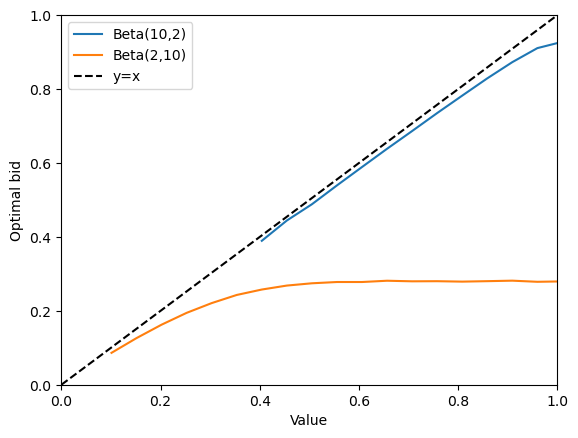

In [56]:
v_grid = np.linspace(0.0, 5.0, 100)

Ev1 = np.empty_like(v_grid)
Ev2 = np.empty_like(v_grid)

for i, v in enumerate(v_grid):
    Ev1[i] = b_star1(v)
    Ev2[i] = b_star2(v)

b_star1_num = interpolate.interp1d(v_grid, Ev1, fill_value='extrapolate')
b_star2_num = interpolate.interp1d(v_grid, Ev2, fill_value='extrapolate')

plt.plot(v_grid, b_star1_num(v_grid), label='Beta(10,2)')
plt.plot(v_grid, b_star2_num(v_grid), label='Beta(2,10)')
#45 graders linje
plt.plot(v_grid, v_grid, '--', label='y=x', color='black')
plt.xlabel('Value')
plt.ylabel('Optimal bid')
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend()


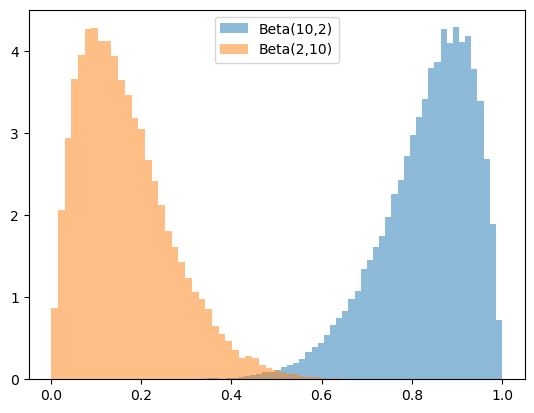

In [57]:
beta1 = np.random.beta(10,2, size=(5,10000)).flatten()
beta2 = np.random.beta(2,10, size=(5,10000)).flatten()

plt.hist(beta1, bins=50, density=True,alpha=0.5, label='Beta(10,2)')
plt.hist(beta2, bins=50, density=True, alpha=0.5, label='Beta(2,10)')
plt.legend()
plt.show()


### 4.4

In [58]:
ev1 = []
ev2 = []

for n in range(2,11):
    beta1 = np.random.beta(2,10, size=(n,T))
    beta2 = np.random.beta(10,2, size=(n,T))
    beta1.sort(axis=0)
    beta2.sort(axis=0)
    v1 = beta1[-2,:]
    v2 = beta2[-2,:]
    ev1.append(np.mean(v1))
    ev2.append(np.mean(v2))

#Dataframe table for n and ev1, ev2
ev1 = pd.DataFrame({'n': range(2,11), 'ev1': ev1})
ev2 = pd.DataFrame({'n': range(2,11), 'ev2': ev2})

# Merge the two dataframes on n
ev = pd.merge(ev1, ev2, on='n', how='outer')
display(ev)


,n,ev1,ev2
0,2,0.108961,0.776497
1,3,0.157174,0.843339
2,4,0.188128,0.873505
3,5,0.209314,0.892374
4,6,0.227437,0.905003
5,7,0.241576,0.913727
6,8,0.253301,0.921024
7,9,0.264254,0.925529
8,10,0.272889,0.930438


### 4.5

In [59]:
np.random.seed(1337)

def marketing1(p):
    beta1 = np.random.beta(2,10, size=(4,T))
    beta1 = np.random.beta(2,10, size=(5,T))
    beta1.sort(axis=0)
    beta2.sort(axis=0)
    v1 = beta1[-2,:]
    v2 = beta2[-2,:]
    return np.abs(np.mean(v1) - (p*(n-2))) - (np.mean(v2) - (p*(n-2)))

def marketing2(p):
    beta1 = np.random.beta(10,2, size=(4,T))
    beta2 = np.random.beta(10,2, size=(5,T))
    beta1.sort(axis=0)
    beta2.sort(axis=0)
    v1 = beta1[-2,:]
    v2 = beta2[-2,:]
    return np.abs(np.mean(v1) - (p*(n-2))) - (np.mean(v2) - (p*(n-2)))

#minimize this shit
result1 = minimize_scalar(marketing1, bounds=(0, 5), method='bounded')
result2 = minimize_scalar(marketing2, bounds=(0, 5), method='bounded')

print(0.210453-0.187064)
print(0.892272-0.873997)


    

0.023388999999999993
0.01827499999999993


### 4.6

In [60]:
ev1 = []
ev11 = []
ev2 = []
ev22 = []

for n in range(2,11):
    beta1 = np.random.beta(2,10, size=(n,T))
    beta2 = np.random.beta(10,2, size=(n,T))
    beta1.sort(axis=0)
    beta2.sort(axis=0)
    #draw from beta dist T times
    tioli1 = np.random.beta(2,10, size=T)
    tioli2 = np.random.beta(10,2, size=T)
    v1 = beta1[-2,:]
    v2 = beta2[-2,:]
    ev1.append(np.mean(v1))
    ev2.append(np.mean(v2))
    ev11.append(np.mean(tioli1))
    ev22.append(np.mean(tioli2))

#Compare ev1 and ev11
ev1 = pd.DataFrame({'n': range(2,11), 'ev1': ev1})
ev11 = pd.DataFrame({'n': range(2,11), 'ev11': ev11})
ev2 = pd.DataFrame({'n': range(2,11), 'ev2': ev2})
ev22 = pd.DataFrame({'n': range(2,11), 'ev22': ev22})

# Merge the two dataframes on n
result1 = pd.merge(ev1, ev11, on='n', how='outer')
result2 = pd.merge(ev2, ev22, on='n', how='outer')
display(result1, result2)

,n,ev1,ev11
0,2,0.110016,0.166933
1,3,0.154964,0.167754
2,4,0.186723,0.168251
3,5,0.208371,0.167134
4,6,0.226799,0.165139
5,7,0.240108,0.167807
6,8,0.254354,0.167347
7,9,0.264006,0.167164
8,10,0.272156,0.168448


,n,ev2,ev22
0,2,0.774179,0.832527
1,3,0.843447,0.834567
2,4,0.874646,0.833857
3,5,0.891647,0.834488
4,6,0.904091,0.833058
5,7,0.913083,0.833012
6,8,0.920273,0.832636
7,9,0.926401,0.832434
8,10,0.930055,0.833877
